In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [2]:
import pandas as pd
import os
from fastai import *
from fastai.vision import *


image_folder = '1024/image_dir_processed'

os.chdir("/home/auri/")
os.getcwd()

'/home/auri'

In [3]:
df = pd.read_csv('Rx-thorax-automatic-captioning/SJ_chest_x_ray_images_labels_160K_Ene19.csv', header = 0, dtype=str)
df.columns

Index(['Unnamed: 0', 'ImageID', 'ImageDir', 'StudyDate_DICOM', 'StudyID',
       'PatientID', 'PatientBirth', 'PatientSex_DICOM', 'ViewPosition_DICOM',
       'Projection', 'MethodProjection', 'Pediatric', 'Modality_DICOM',
       'Manufacturer_DICOM', 'PhotometricInterpretation_DICOM',
       'PixelRepresentation_DICOM', 'PixelAspectRatio_DICOM',
       'SpatialResolution_DICOM', 'BitsStored_DICOM', 'WindowCenter_DICOM',
       'WindowWidth_DICOM', 'Rows_DICOM', 'Columns_DICOM',
       'XRayTubeCurrent_DICOM', 'Exposure_DICOM', 'ExposureInuAs_DICOM',
       'ExposureTime', 'RelativeXRayExposure_DICOM', 'ReportID', 'Report',
       'MethodLabel', 'Labels', 'Localizations',
       'LabelsLocalizationsBySentence', 'labelCUIS', 'LocalizationsCUIS'],
      dtype='object')

In [4]:
#create field with labels flattened to a single sequence
import ast
def delabel(labels):
    r = None
    if labels is not None:
        try:
            r = pd.Series([label.strip() for label in  ast.literal_eval(labels)]).dropna().values
        except:
            r = None
    return r
    
df.loc[:,'labels'] = df.loc[:,'Labels'].apply(lambda l: delabel(l))

In [5]:
#create field with labels and locations  flattened to a single sequence
#uncomment only to train a model to predict both labels and locations
def delabel_loc(labels):
    r = None
    if labels is not None:
        try:
            r = pd.Series([label.replace('loc ','').strip() for sublist in  ast.literal_eval(labels) for label in sublist]).dropna().values
        except:
            r = None
    return r
    
#df.loc[:,'labelslocs'] = df.loc[:,'LabelsLocalizationsBySentence'].apply(lambda l: delabel_loc(l))




In [6]:
#Reports null are filtered (n = 103)
df_fastai = df.loc[df.labels.isna() == False,['ImageID','labels','LabelsLocalizationsBySentence','Projection','Pediatric', 'StudyDate_DICOM', 'PatientBirth','MethodLabel', 'PatientID']]
print(df_fastai.shape)

(160758, 9)


In [7]:
#corrupted images are filtered (n < 40)
corrupt_images = pd.read_csv('SJ/badfiles__.txt', dtype=str)
corrupt_images = corrupt_images.iloc[:,0].str.replace(image_folder,'').str.replace("'",'').values

df_fastai = df_fastai.loc[df_fastai.ImageID.isin(corrupt_images) == False,:]
df_fastai.shape

(160758, 9)

In [8]:
import glob
filter_images = pd.Series(glob.glob(f"/home/auri/SJ/{image_folder}/*.png")).str.replace(f'/home/auri/SJ/{image_folder}/','')
print(filter_images.describe())
df_fastai = df_fastai.loc[df_fastai.ImageID.isin(filter_images),]
df_fastai.shape

count                                                167257
unique                                               167257
top       216840111366964013686042548532013295144435553_...
freq                                                      1
dtype: object


(160725, 9)

In [9]:
#Pediatric images are filtered
df_fastai = df_fastai.loc[df_fastai['Pediatric'] != 'PED',]
print(df_fastai.shape)
df_fastai.head()

#In many pediatric images (n aprox 3300), none of the DICOM field are tagged as pediatric, so as an additional measure we remove patients less than 5 years old
#StudyDate_DICOM PatientBirth
df_fastai['age'] = df_fastai.StudyDate_DICOM.str.slice(0, 4).astype('float') - df_fastai.PatientBirth.astype('float') 

df_fastai =df_fastai.loc[df_fastai['age'] > 5.0,]
print(df_fastai.shape)

(160451, 9)
(157096, 10)


In [10]:
patho_list = ["atelectasis", "cardiomegaly", "cardiac", 
              "pleural effusion", "infiltrates", "mass", "nodule",
             "pneumonia", "pneumothorax", 
              "consolidation", "pulmonary edema",
             "emphysema", "pulmonary fibrosis", "pleural thickening",
             "hiatal hernia", "granuloma", "chronic changes", #scaring is not exactly equal to chronic changes, but more to fibrosis, but PLCO has other term with fibrosis
              "bone", "soft tissue",
             "COPD signs", "hilar", "normal"]

#Frontal images are selected
print(df_fastai.Projection.value_counts())
frontal = ['PA', 'AP_horizontal', 'AP']
df_fastai = df_fastai.loc[df_fastai['Projection'].isin(frontal),['ImageID','labels','Projection','Pediatric','MethodLabel', 'PatientID','LabelsLocalizationsBySentence']]
print(df_fastai.shape)


#"exclude" labeled reports  are filtered
df_fastai = df_fastai[~ df_fastai.labels.map(lambda x: 'exclude'  in x and x.shape[0] == 1)]
print(df_fastai.shape)

#"suboptimal study" reported images are filtered
df_fastai = df_fastai[~ df_fastai.labels.map(lambda x: 'suboptimal study'  in x and x.shape[0] == 1)]
print(df_fastai.shape)



#create new pandas with field "normal" True or False
normal = df_fastai[df_fastai.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1)]
print(normal.shape)
df_fastai_normal = df_fastai[['ImageID','labels','LabelsLocalizationsBySentence']]
df_fastai_normal.loc[:,'Normal'] = False
df_fastai_normal.loc[df_fastai.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1),'Normal' ] = True

print(df_fastai_normal.head())


PA               90375
L                48956
AP_horizontal    13690
AP                3446
COSTAL             618
EXCLUDE             11
Name: Projection, dtype: int64
(107511, 7)
(106581, 7)
(106308, 7)
(34966, 7)


/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


                                             ImageID  \
0  20536686640136348236148679891455886468_k6ga29.png   
2  135803415504923515076821959678074435083_fzis7b...   
3  113855343774216031107737439268243531979_3k951l...   
5  313903302629300007485735352869488750471_75sg0k...   
7  3137231742710829928-247610802266403640553_kine...   

                                              labels  \
0                                           [normal]   
2  [pulmonary fibrosis, chronic changes, kyphosis...   
3                                  [chronic changes]   
5  [unchanged, alveolar pattern, interstitial pat...   
7  [laminar atelectasis, pleural effusion, apical...   

                       LabelsLocalizationsBySentence  Normal  
0                           [['normal'], ['normal']]    True  
2  [['pulmonary fibrosis', 'loc basal bilateral']...   False  
3  [['chronic changes'], ['chronic changes'], ['n...   False  
5  [['unchanged'], ['alveolar pattern', 'intersti...   False  
7  [['lamin

In [11]:
#filter physician labeled
#df_fastai_filter = df_fastai.loc[df_fastai.MethodLabel.isin(['Physician']), ['ImageID','labels']]
#print(df_fastai_filter.columns)
#df_fastai_filter.reset_index(inplace = True, drop=True)
#df_fastai_filter.head()

#filter effusion and select equal number of normal to balance
f = ['pleural effusion']
df_fastai_p = df_fastai.loc[df_fastai.labels.map(lambda x: 'pleural effusion'  in x ), ['ImageID','labels', 'PatientID','LabelsLocalizationsBySentence']]
#import re

#df_fastai_p = df_fastai.loc[df_fastai.labels.str.findall('(.*)?pleural effusion(.*)?'), ['ImageID','labels', 'PatientID','LabelsLocalizationsBySentence']]

df_fastai_p['effusion'] = True
print(df_fastai_p.shape)
normal = df_fastai_normal.loc[df_fastai_normal.Normal == True,][:df_fastai_p.shape[0]]
normal['effusion'] = False


(6886, 5)


In [12]:
#split by patient so that the same patient is on either training or val set but never on both
unique = df_fastai_p.PatientID.value_counts()
multiple = unique.loc[unique > 1]
unique = unique.loc[unique == 1]


#strategy: add multiple observations of patients only to the training set following same principle as augmentation
train = df_fastai_p.loc[df_fastai_p.PatientID.isin(multiple.index),]

unique_p = df_fastai_p.loc[df_fastai_p.PatientID.isin(unique.index),]


#complete  up to the rest
n = int(df_fastai_p.shape[0] * 0.8)
_rest = n - train.shape[0]
add_train = unique_p[:_rest][['ImageID','labels','PatientID','effusion','LabelsLocalizationsBySentence']]
print(add_train.shape[0])
normal_train = normal[:n]
train = pd.concat([train, add_train, normal_train])

train = train[['ImageID','labels','effusion','PatientID','LabelsLocalizationsBySentence']]

normal_val = normal[n:]
val = unique_p[_rest:][['ImageID','labels','PatientID','effusion','LabelsLocalizationsBySentence']]
val = pd.concat([val, normal_val])
val = val[['ImageID','labels','effusion','PatientID','LabelsLocalizationsBySentence']]

print(train.shape)
print(train.PatientID.value_counts())
print(val.PatientID.value_counts())
print(val.shape)

df_final = pd.concat([ train,val], ignore_index=True)

print(df_final.iloc[0,:])
df_final['ImageDir'] = 0
df_final.to_csv('Rx-thorax-automatic-captioning/image_prediction/effusion.csv', index=True)

#df_final = pd.concat([df_fastai_p, normal])
#df_final.reset_index(inplace= True, drop=True)
#df_final = df_final[['ImageID','labels','pneumothorax']]



972
(11016, 5)
168550076836128609595241571786282061120    23
195747366141824265708856514010055767883    22
19402892008193776255944927672864227677     22
210546110238931506228438823506416410       21
99628540441498750204293448351279011624     21
194959933537228003282045267699735693237    21
185381733354484107213785859726474818645    21
227403516711108225380748794190903914177    19
13324023031650046244153718483695924259     19
59632809453047710808330168071592829622     18
274064412965433183908763443227787634177    18
42064372869969676351178376950870448639     16
85141099061342358383555722758783004890     15
326518275156087582596219856724017230827    14
191495044394919363449271589557811628010    14
208267780451157453725181702410606225282    14
297622738482822497075403702921136436597    13
95200291215790294039423573056515523115     13
206928222647867818713300493040865438965    13
162011243614680351492915389156480617040    13
182951320728563478161912750837024873370    13
8470110425391972562

/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [13]:
#from sklearn.model_selection import train_test_split
#train, val = train_test_split(df_final, random_state=42, test_size=0.2, shuffle=True)

In [14]:
n = int(df_final.shape[0] * 0.8)
train = df_final[:n]
val = df_final[n:]
print(train.PatientID.value_counts())
print(val.PatientID.value_counts())
print(val.index.values)

168550076836128609595241571786282061120    23
19402892008193776255944927672864227677     22
195747366141824265708856514010055767883    22
99628540441498750204293448351279011624     21
185381733354484107213785859726474818645    21
194959933537228003282045267699735693237    21
210546110238931506228438823506416410       21
13324023031650046244153718483695924259     19
227403516711108225380748794190903914177    19
274064412965433183908763443227787634177    18
59632809453047710808330168071592829622     18
42064372869969676351178376950870448639     16
85141099061342358383555722758783004890     15
191495044394919363449271589557811628010    14
326518275156087582596219856724017230827    14
208267780451157453725181702410606225282    14
206928222647867818713300493040865438965    13
95200291215790294039423573056515523115     13
329858144230247980268667671042805831511    13
297622738482822497075403702921136436597    13
162011243614680351492915389156480617040    13
8470110425391972562564070734475027

In [15]:
import cv2
def open_png16(self, fn):
    img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED).astype(np.float32)/65535
    return Image(torch.tensor(img).unsqueeze(0).expand((3,-1,-1)))
#open_png16(fn ="SJ/image_dir_processed/113855343774216031107737439268243531979_3k951l.png")

In [16]:
#Replace with the path to image folder 
p = "/home/auri/SJ/"
bach_size = 16

In [17]:
import cv2
class MyImageItemList(ImageList):
    def open(self,fn):
        img = None
        try:
            img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED).astype(np.float32)/65535
        except:
            print(fn)
        return Image(torch.tensor(img).unsqueeze(0).expand((3,-1,-1)))

In [18]:
p,image_folder

('/home/auri/SJ/', '1024/image_dir_processed')

In [19]:
data = (MyImageItemList.from_df(
    df = df_final, path = p, 
    folder=image_folder))                      


In [20]:
data = (MyImageItemList.from_df(
    df = df_final, path = p, 
    folder=image_folder).split_by_idx(valid_idx=val.index.values).label_from_df(
    cols='effusion').transform(
    get_transforms(do_flip = False, max_rotate = 5.0, max_zoom = 0, max_warp = None), 
    size=(1500,1500)).databunch(bs=bach_size).normalize())                          

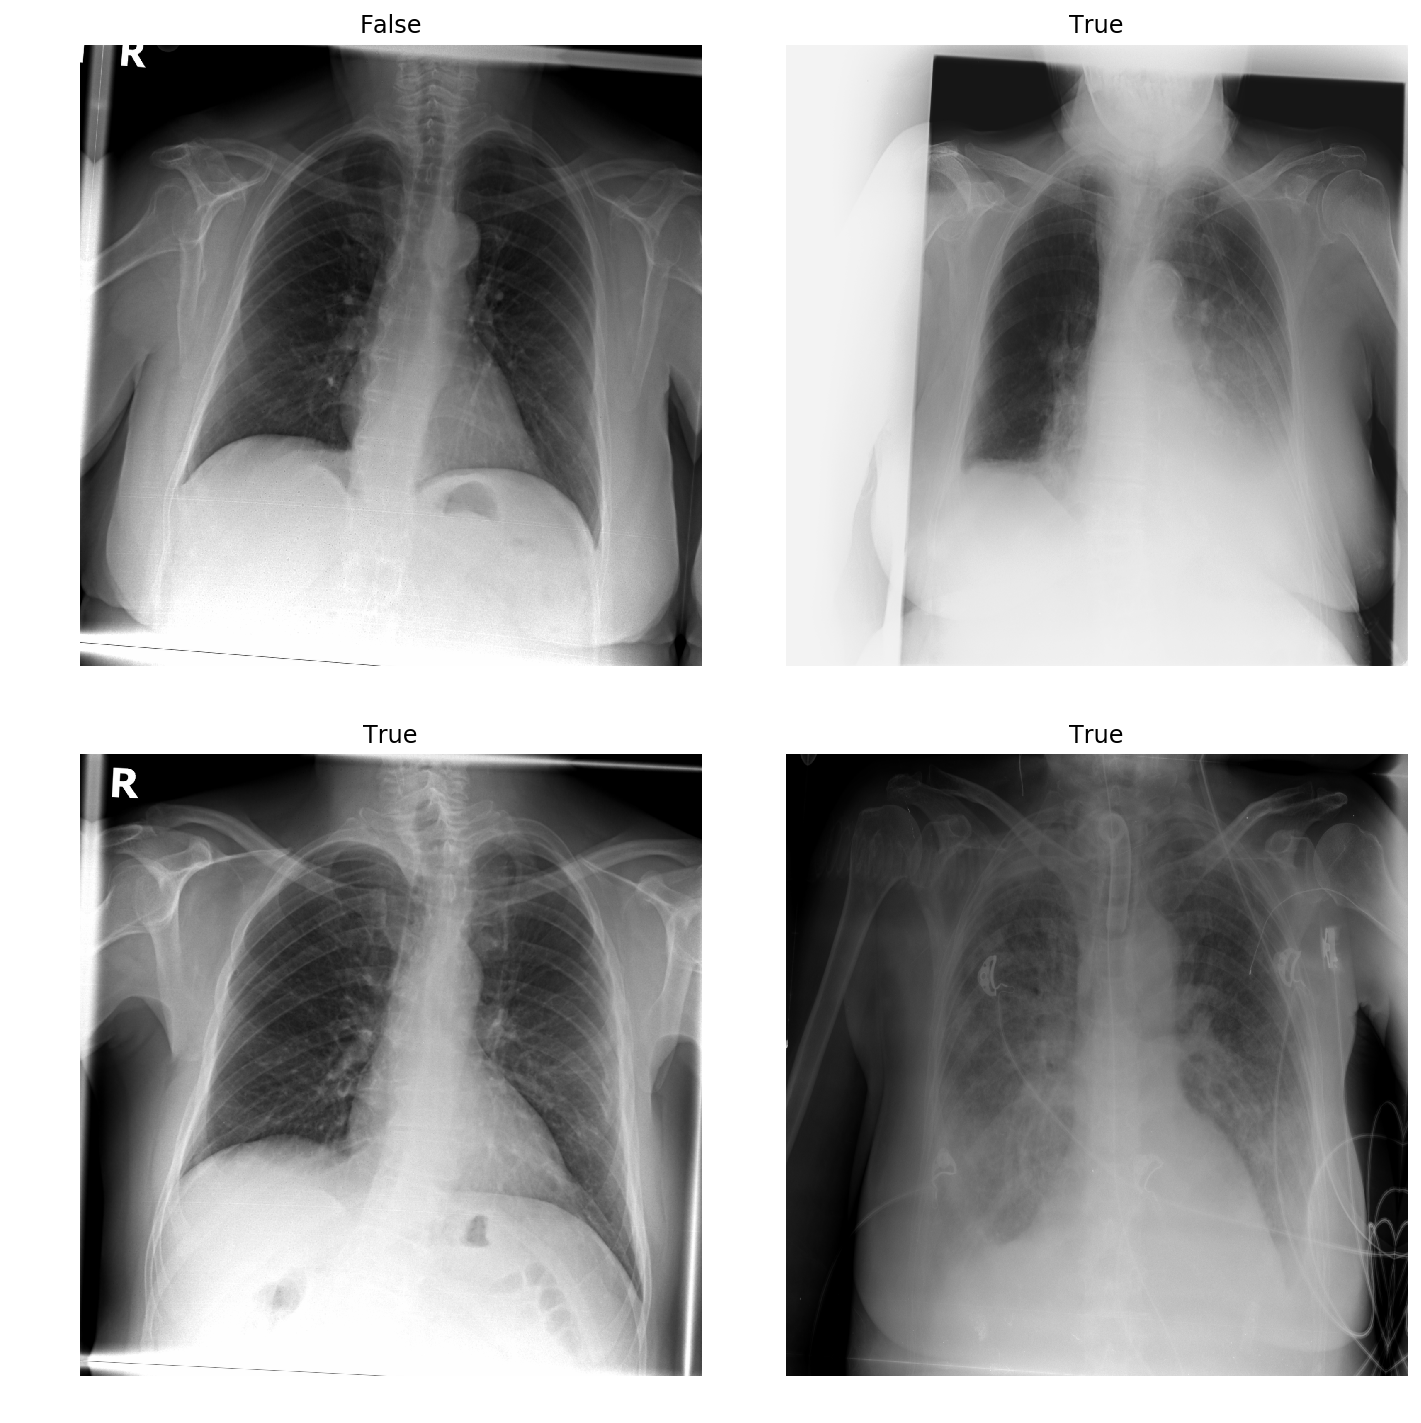

In [21]:
data.show_batch(rows=2, figsize=(10,10))


In [22]:
data.classes

[False, True]

False
ImageID                          24486276148682497801853856901449479477_wapay9.png
labels                                                                    [normal]
effusion                                                                     False
PatientID                                                                      NaN
LabelsLocalizationsBySentence                                         [['normal']]
ImageDir                                                                         0
Name: 13766, dtype: object


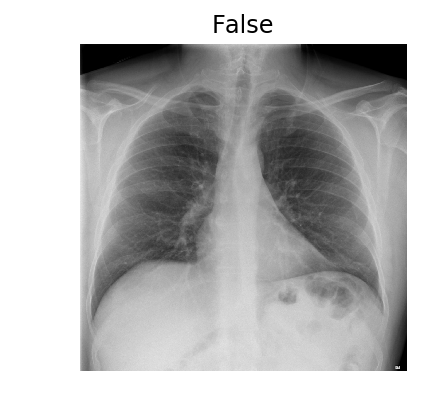

In [23]:
#show one study example from validation set
img,labels = data.valid_ds[-6]
print(labels)
print(df_final.loc[val.index.values[-6],])
img.show(title=str(labels))


In [24]:
class AverageMetric(Callback):
    def __init__(self, func):
        self.func, self.name = func, func.__name__

    def on_epoch_begin(self, **kwargs):
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, train, **kwargs):
        self.count += last_target.size(0)
        self.val += last_target.size(0) * self.func(last_output, last_target).detach().item()

    def on_epoch_end(self, **kwargs):
        self.metric = self.val/self.count


NOT USED

class Precision(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.correct, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.correct += ((preds==1) * (last_target==1)).float().sum()
        self.total += (preds==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        self.metric = self.correct/self.total
        
class Recall(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.correct, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.correct += ((preds==1) * (last_target==1)).float().sum()
        self.total += (last_target==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        self.metric = self.correct/self.total

In [25]:
from fastai.imports import *
from sklearn.metrics import fbeta_score
import warnings
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return torch.tensor(max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)]))
def f2_micro(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ([fbeta_score(targs, (preds>th), 2, average='micro')
                    for th in np.arange(start,end,step)])
def f2_macro(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ([fbeta_score(targs, (preds>th), 2, average='macro')
                    for th in np.arange(start,end,step)])
def f2_w(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return ([fbeta_score(targs, (preds>th), 2, average='weighted')
                    for th in np.arange(start,end,step)])

In [26]:
Precision

fastai.metrics.Precision

In [31]:
learn = None
gc.collect()
torch.cuda.empty_cache()

In [32]:
learn = cnn_learner(data,
                   models.resnet18,
                   metrics=[accuracy,  Precision(), Recall()],
                   loss_func= LabelSmoothingCrossEntropy() ).mixup(alpha=0.2).to_fp16()#, f2_micro, f2_macro, f2_w])



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


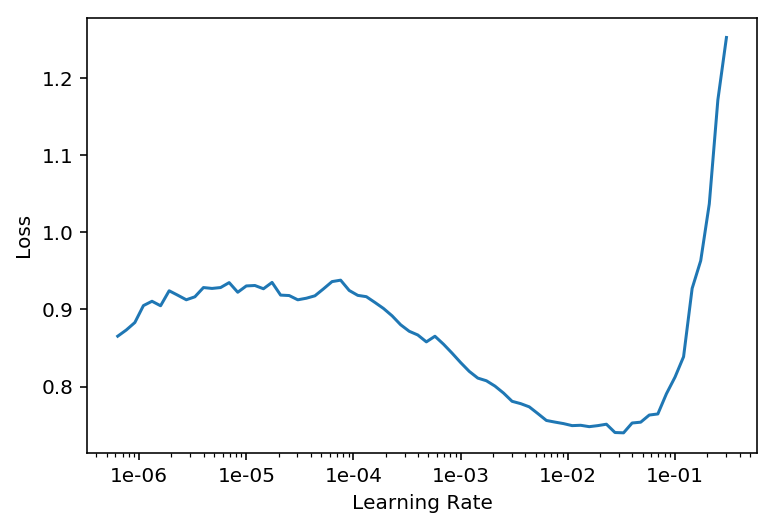

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(5, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.455504,0.342495,0.921960,0.912642,0.933188,06:51
1,0.395588,0.295717,0.956443,0.965211,0.946986,06:52
2,0.379732,0.312655,0.932486,0.985330,0.877996,06:57
3,0.367226,0.277404,0.961162,0.981791,0.939724,06:52
4,0.365676,0.276608,0.965517,0.984139,0.946260,06:55


In [35]:
learn.save('predict-effusion-patient-split-3')

In [36]:
learn.load('predict-effusion-patient-split-3')

Learner(data=ImageDataBunch;

Train: LabelList (11017 items)
x: MyImageItemList
Image (3, 1500, 1500),Image (3, 1500, 1500),Image (3, 1500, 1500),Image (3, 1500, 1500),Image (3, 1500, 1500)
y: CategoryList
True,True,True,True,True
Path: /home/auri/SJ;

Valid: LabelList (2755 items)
x: MyImageItemList
Image (3, 1500, 1500),Image (3, 1500, 1500),Image (3, 1500, 1500),Image (3, 1500, 1500),Image (3, 1500, 1500)
y: CategoryList
True,True,True,True,True
Path: /home/auri/SJ;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-2
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit_one_cycle(max_lr = lrs,  cyc_len=1)

In [ ]:
doc(create_cnn)

In [ ]:
learn.unfreeze()


In [ ]:
learn.lr_find()


In [ ]:
learn.recorder.plot()

In [ ]:
learn.loss_func.func

In [ ]:
#learn.fit_one_cycle(30, max_lr = lrs)
learn.fit_one_cycle(5, max_lr=slice(1e-5,3e-4))

In [37]:

preds,y,losses = learn.get_preds(with_loss=True)


In [38]:
interp = ClassificationInterpretation(learn, preds, y, losses)


In [39]:
interp.top_losses()


(tensor([3.4060, 3.0419, 2.7560,  ..., 0.1985, 0.1985, 0.1985]),
 tensor([ 146,  230,  829,  ..., 2308, 2083, 2041]))

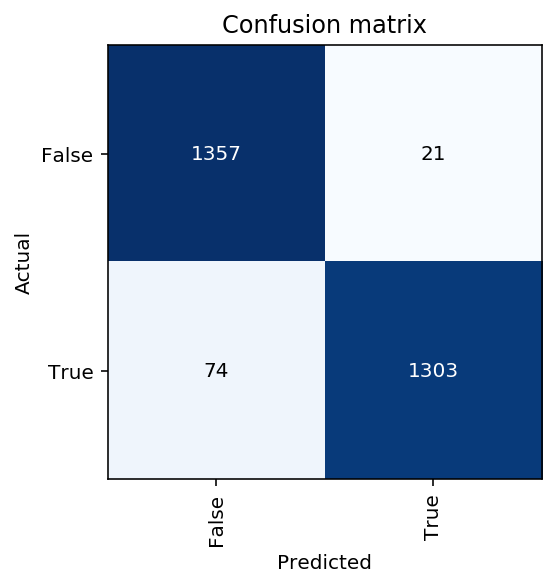

In [40]:
interp.plot_confusion_matrix()


In [68]:
#interp.plot_top_losses(2, figsize=(7,7))

In [46]:
interp.top_losses()

(tensor([3.4060, 3.0419, 2.7560,  ..., 0.1985, 0.1985, 0.1985]),
 tensor([ 146,  230,  829,  ..., 2308, 2083, 2041]))

ImageID                          216840111366964012373310883942009189112337416_...
labels                           [pleural effusion, COPD signs, aortic elongation]
effusion                                                                      True
PatientID                                  325756787782438930229733308342309329619
LabelsLocalizationsBySentence    ['pleural effusion', 'loc pleural', 'exclude',...
ImageDir                                                                         0
Name: 11846, dtype: object
Actual Effusion: True
Predicted Effusion: False


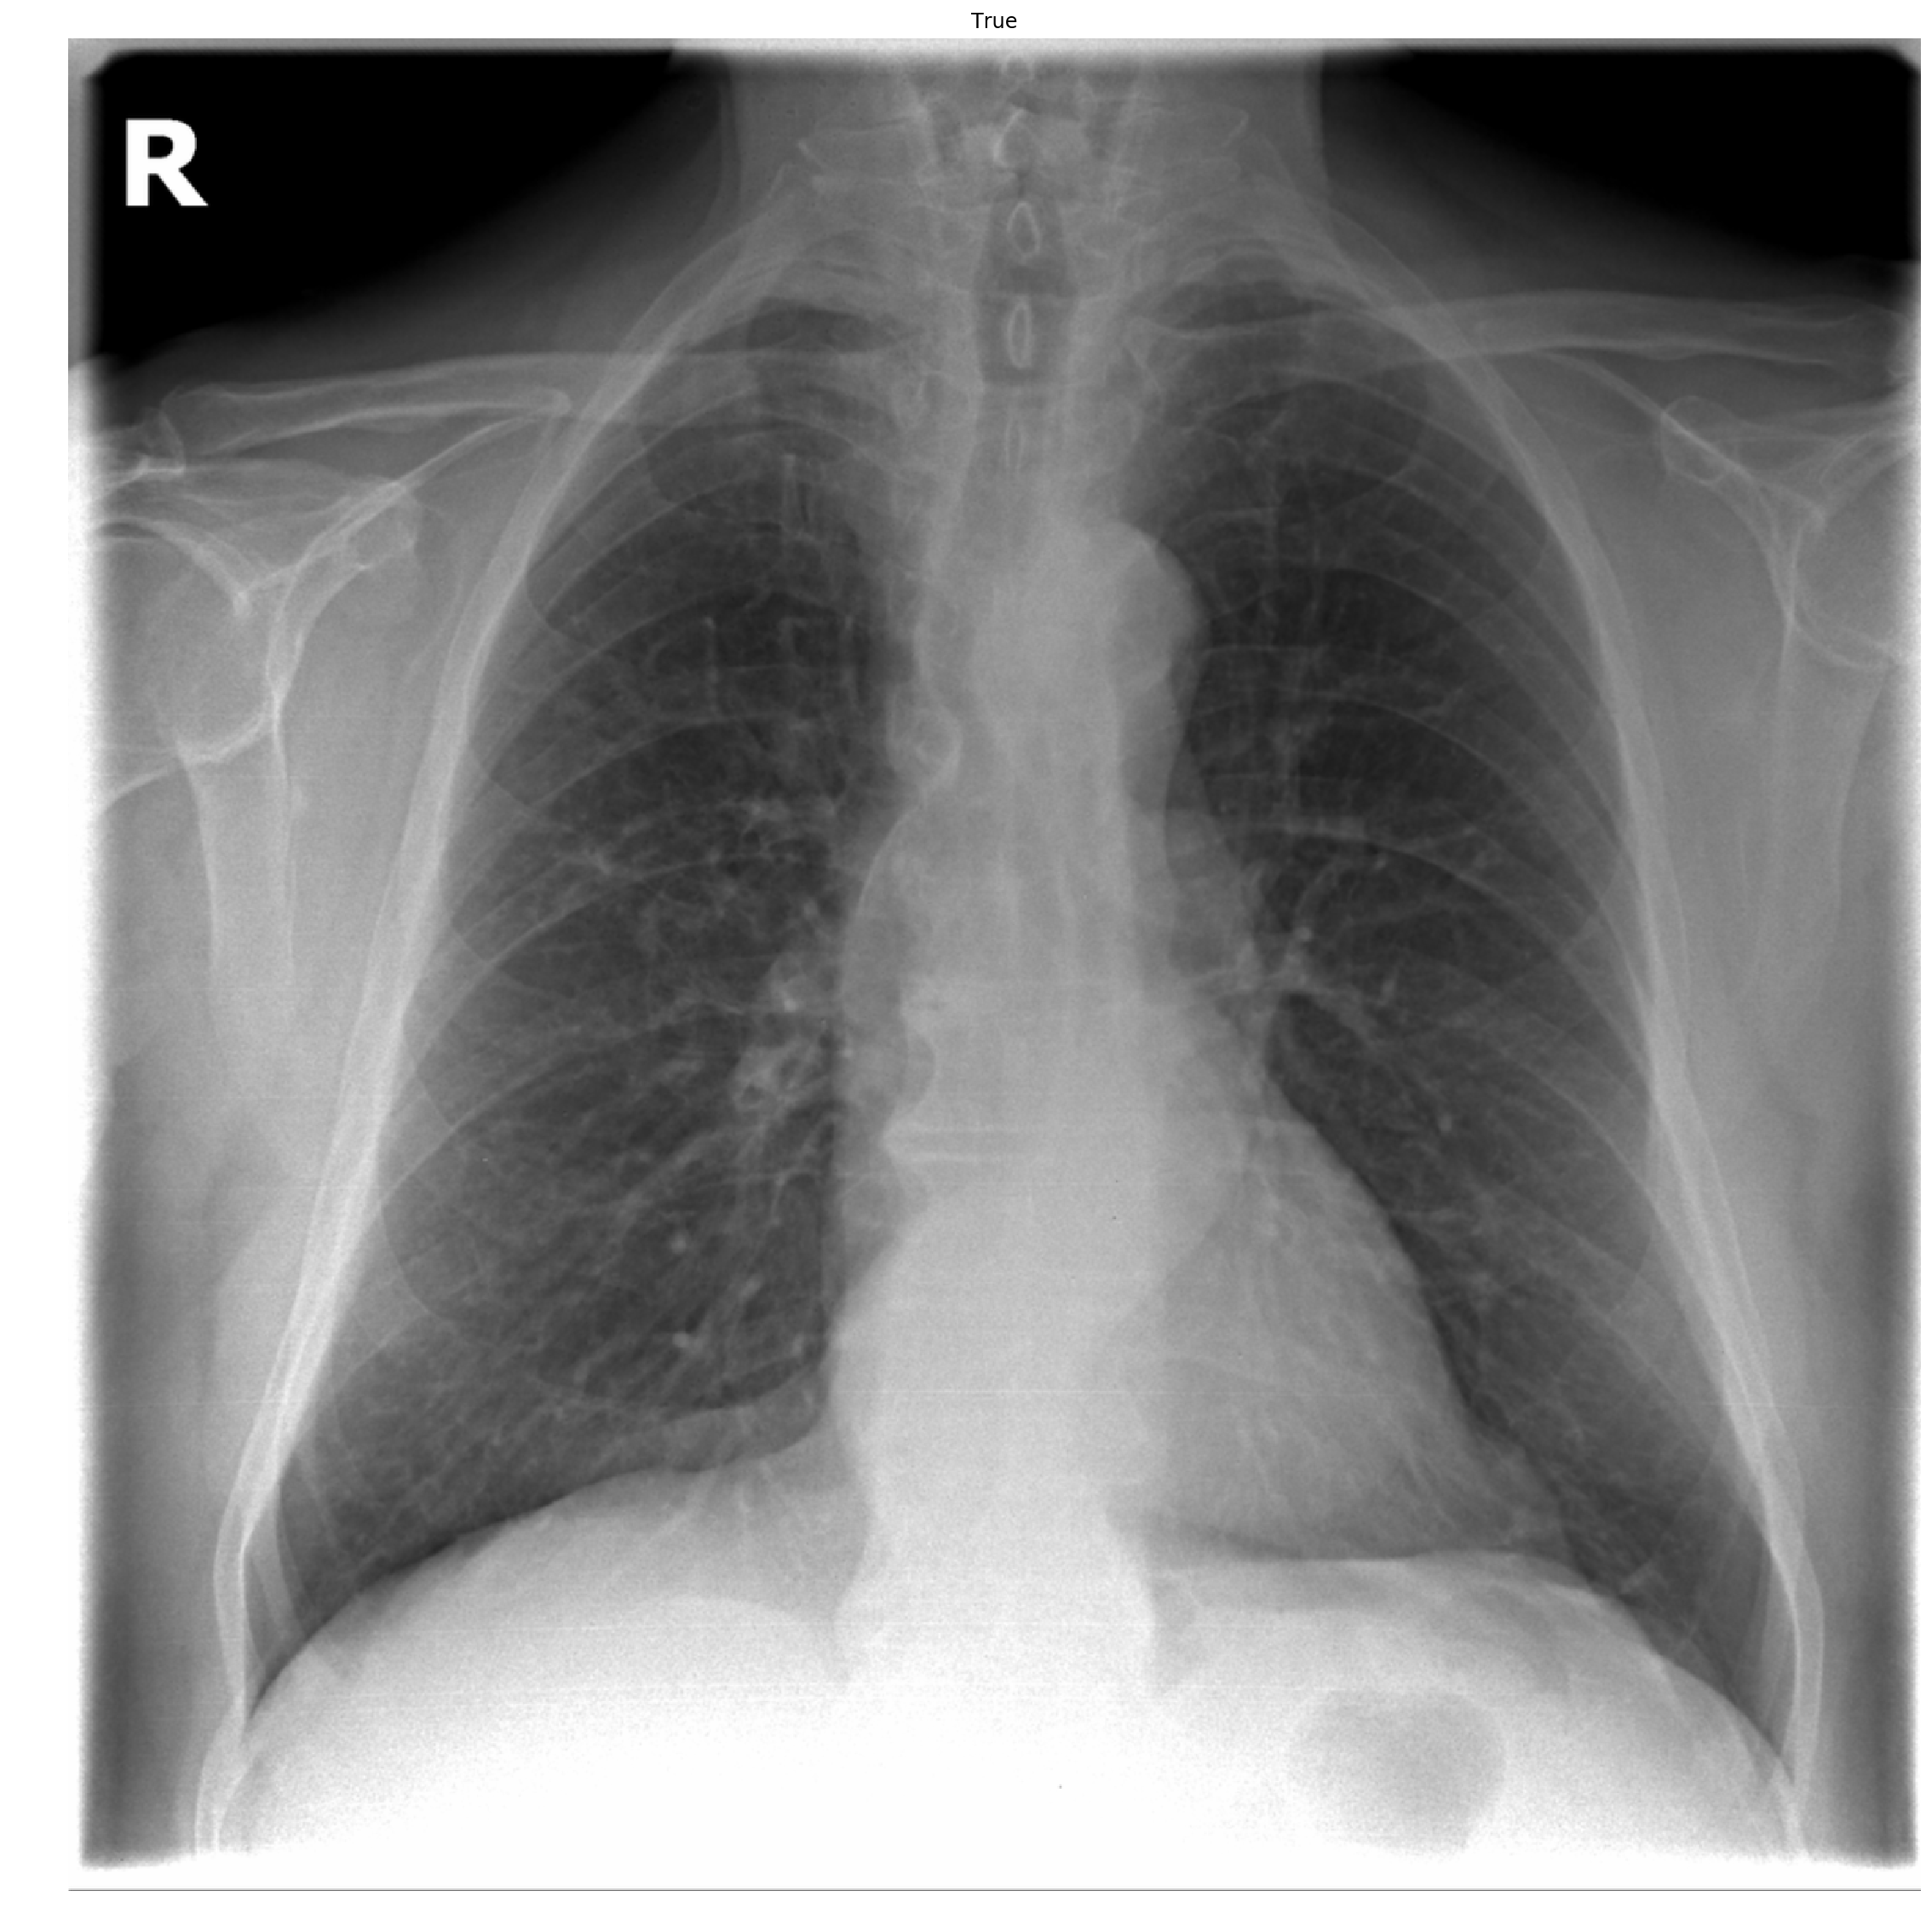

In [52]:
#Normal = 0, effusion= 1 
item =829
img,labels = data.valid_ds[item]

print(val.iloc[item])
#print(df_final.loc[val.index.values[item], ['ImageID']])
#print(df_final.loc[val.index.values[item], 'LabelsLocalizationsBySentence'])

print('Actual Effusion: {}'.format(labels))
predicted = bool(np.argmax(preds[item], axis=0))
print('Predicted Effusion: {}'.format(predicted))
img.show(title=str(labels), figsize=(20,20) )


In [50]:
#HeatMap
m = learn.model.eval().half()
m#.half()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [51]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 750, 750]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 750, 750]       128        True      
______________________________________________________________________
ReLU                 [64, 750, 750]       0          False     
______________________________________________________________________
MaxPool2d            [64, 375, 375]       0          False     
______________________________________________________________________
Conv2d               [64, 375, 375]       36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 375, 375]       128        True      
______________________________________________________________________
ReLU                 [64, 375, 375]       0          False     
______________________________________________________________

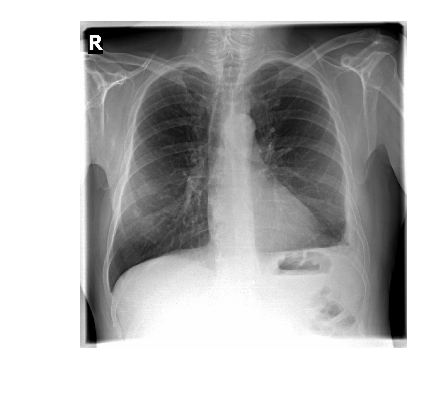

In [58]:
item =6
x,y = data.valid_ds[item]
x.show()
#data.valid_ds.y[idx]

In [59]:

xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda().half()


In [60]:
from fastai.callbacks.hooks import *


In [61]:
def hooked_backward(cat= y):
  
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [62]:
hook_a,hook_g = hooked_backward()

In [63]:
hook_a.stored.size()

torch.Size([1, 512, 47, 47])

In [64]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 47, 47])

In [65]:
acts = acts.to(torch.float32)
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([47, 47])

In [66]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.7, extent=(0,1500,1500,0),
              interpolation='bilinear', cmap='magma');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


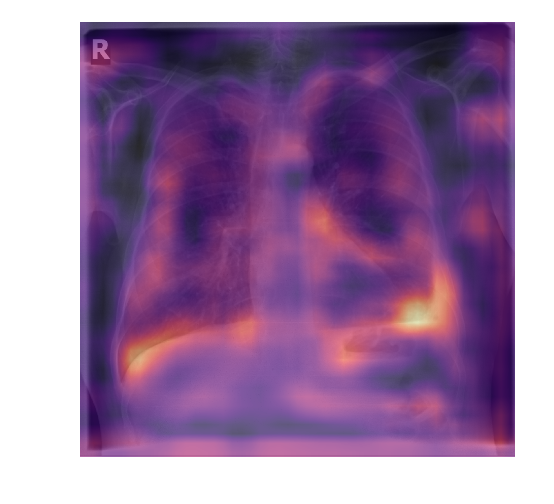

In [67]:
show_heatmap(avg_acts)

In [ ]:
print(data.train_ds)

In [ ]:
print(data.valid_ds.x[0])